In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import csv
from tqdm import tqdm
import pandas as pd

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

In [2]:
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset

'''
label = 0: front, 1:backward, 2:right, 3:jelly
'''

# The directories and the corresponding labels
directories = [os.path.join(".", "output_front_ppo"), os.path.join(".", "output_bw_sac"), 
               os.path.join(".", "output_right_ppo"), os.path.join(".", "output_jelly")]
labels = [0, 1, 2, 3]  # Change this to your actual labels

datasets = []  # List to store datasets from each directory

for directory, label in zip(directories, labels):
    # Get all subdirectories
    subdirs = [f.path for f in os.scandir(directory) if f.is_dir()]
    subdirs.sort()

    # Create an empty 3D array to store the combined data
    combined_arr = np.zeros((len(subdirs), 1000, 10))  # Use np.zeros instead of np.empty

    for i, subdir in enumerate(subdirs):
        # Load the action and obs CSV files
        action_df = pd.read_csv(os.path.join(subdir, "action.csv"), header=None)
        obs_df = pd.read_csv(os.path.join(subdir, "obs.csv"), header=None)

        # Concatenate the DataFrames horizontally and convert to a 3D array
        combined_data = pd.concat([action_df, obs_df], axis=1)
        combined_arr[i] = np.reshape(combined_data.values, (1000, 10))  # Use i instead of i-1

        # Convert to tensor and add a dimension for the batch size
        combined_tensor = torch.from_numpy(combined_arr[i]).unsqueeze(0)

        # Create a TensorDataset and append it to the list
        datasets.append(TensorDataset(combined_tensor, torch.tensor([label])))

# Concatenate all datasets
dataset = ConcatDataset(datasets)

# VAE code -1

Training for label 0
====> Epoch: 1 Average loss: 0.007953635096549987, Recon Loss: 0.003957887589931488, KL Div: 0.019978737030710493
====> Epoch: 2 Average loss: 0.005824091417448861, Recon Loss: 0.003925297890390669, KL Div: 0.009493967396872385
====> Epoch: 3 Average loss: 0.005568992938314165, Recon Loss: 0.003893114984035492, KL Div: 0.008379389558519636
====> Epoch: 4 Average loss: 0.005370989952768598, Recon Loss: 0.0038602546623774936, KL Div: 0.007553676264626639
====> Epoch: 5 Average loss: 0.005187354258128575, Recon Loss: 0.0038256651163101198, KL Div: 0.006808445598397936
====> Epoch: 6 Average loss: 0.005008895652634757, Recon Loss: 0.0037883398958614895, KL Div: 0.006102778766836439
====> Epoch: 7 Average loss: 0.004836293969835554, Recon Loss: 0.0037482859918049403, KL Div: 0.005440039685794286
====> Epoch: 8 Average loss: 0.0046751362936837335, Recon Loss: 0.0037050352692604067, KL Div: 0.004850504985877446
====> Epoch: 9 Average loss: 0.004519900023937226, Recon Loss

====> Epoch: 71 Average loss: 0.00037743960853133885, Recon Loss: 0.0003773743723120008, KL Div: 3.261821610586984e-07
====> Epoch: 72 Average loss: 0.000375309665288244, Recon Loss: 0.0003752444375838552, KL Div: 3.261481012616839e-07
====> Epoch: 73 Average loss: 0.0003728527788605009, Recon Loss: 0.00037279197254351206, KL Div: 3.040220056261335e-07
====> Epoch: 74 Average loss: 0.00036995758754866464, Recon Loss: 0.00036989699197666984, KL Div: 3.0297892434256415e-07
====> Epoch: 75 Average loss: 0.00036965820299727576, Recon Loss: 0.000369598357805184, KL Div: 2.9922383172171456e-07
====> Epoch: 76 Average loss: 0.0003698424186025347, Recon Loss: 0.0003697815729039056, KL Div: 3.0422636440822055e-07
====> Epoch: 77 Average loss: 0.0003652225477354867, Recon Loss: 0.00036517104825803214, KL Div: 2.574920654296875e-07
====> Epoch: 78 Average loss: 0.0003649819301707404, Recon Loss: 0.0003649294323154858, KL Div: 2.624945981161935e-07
====> Epoch: 79 Average loss: 0.00036475172745329

====> Epoch: 140 Average loss: 0.00034006674800600325, Recon Loss: 0.00034003949591091703, KL Div: 1.362689903804234e-07
====> Epoch: 141 Average loss: 0.00034036400594881605, Recon Loss: 0.00034033688477107455, KL Div: 1.3559630938938687e-07
====> Epoch: 142 Average loss: 0.0003423442521265575, Recon Loss: 0.0003423142646040235, KL Div: 1.4994825635637555e-07
====> Epoch: 143 Average loss: 0.00034294098083462036, Recon Loss: 0.0003429101194654192, KL Div: 1.5430365289960588e-07
====> Epoch: 144 Average loss: 0.0003425127587148121, Recon Loss: 0.0003424842623727662, KL Div: 1.4248064586094448e-07
====> Epoch: 145 Average loss: 0.0003419287481478282, Recon Loss: 0.0003419046199747494, KL Div: 1.206355435507638e-07
====> Epoch: 146 Average loss: 0.00034178160982472553, Recon Loss: 0.00034174993421350205, KL Div: 1.583780561174665e-07
====> Epoch: 147 Average loss: 0.0003420114453349795, Recon Loss: 0.00034198632836341856, KL Div: 1.2558698654174806e-07
====> Epoch: 148 Average loss: 0.00

====> Epoch: 9 Average loss: 0.008172943813460214, Recon Loss: 0.00816601118019649, KL Div: 3.466338344982692e-05
====> Epoch: 10 Average loss: 0.008075643062591552, Recon Loss: 0.008069512571607318, KL Div: 3.065247195107596e-05
====> Epoch: 11 Average loss: 0.007993068984576635, Recon Loss: 0.007987509574208941, KL Div: 2.7797005006245203e-05
====> Epoch: 12 Average loss: 0.00791196506364005, Recon Loss: 0.007906893151147025, KL Div: 2.5359583752495902e-05
====> Epoch: 13 Average loss: 0.007827575496264866, Recon Loss: 0.007822971888950894, KL Div: 2.301797696522304e-05
====> Epoch: 14 Average loss: 0.007766975045204162, Recon Loss: 0.007762802515711103, KL Div: 2.0862570830753872e-05
====> Epoch: 15 Average loss: 0.0076772349221365796, Recon Loss: 0.007673359394073486, KL Div: 1.937751259122576e-05
====> Epoch: 16 Average loss: 0.007606644051415579, Recon Loss: 0.0076030313968658446, KL Div: 1.8063311065946306e-05
====> Epoch: 17 Average loss: 0.007545513016836983, Recon Loss: 0.007

====> Epoch: 80 Average loss: 0.005829191701752799, Recon Loss: 0.005828471217836652, KL Div: 3.6025983946663993e-06
====> Epoch: 81 Average loss: 0.005848906465939113, Recon Loss: 0.00584822530405862, KL Div: 3.405741282871791e-06
====> Epoch: 82 Average loss: 0.005830442496708462, Recon Loss: 0.005829767329352243, KL Div: 3.375824008669172e-06
====> Epoch: 83 Average loss: 0.00583717041356223, Recon Loss: 0.005836461390767779, KL Div: 3.545203379222325e-06
====> Epoch: 84 Average loss: 0.005827660781996591, Recon Loss: 0.005826924000467573, KL Div: 3.6837203162057058e-06
====> Epoch: 85 Average loss: 0.005824631742068699, Recon Loss: 0.005823683738708496, KL Div: 4.739846502031599e-06
====> Epoch: 86 Average loss: 0.005798540200505938, Recon Loss: 0.005797660878726414, KL Div: 4.396847316196987e-06
====> Epoch: 87 Average loss: 0.005810008679117475, Recon Loss: 0.005809369512966701, KL Div: 3.1956136226654054e-06
====> Epoch: 88 Average loss: 0.0058061591897692, Recon Loss: 0.0058055

====> Epoch: 150 Average loss: 0.005752893005098615, Recon Loss: 0.005751708967345101, KL Div: 5.9203292642320906e-06
====> Epoch: 151 Average loss: 0.005786118405205863, Recon Loss: 0.00578552314213344, KL Div: 2.976128033229283e-06
====> Epoch: 152 Average loss: 0.005809460963521685, Recon Loss: 0.0058083929845264975, KL Div: 5.340239831379482e-06
====> Epoch: 153 Average loss: 0.00577288476058415, Recon Loss: 0.005772029280662536, KL Div: 4.277420895440238e-06
====> Epoch: 154 Average loss: 0.005772891845021929, Recon Loss: 0.005771873644420079, KL Div: 5.091049841472081e-06
====> Epoch: 155 Average loss: 0.005786549653325762, Recon Loss: 0.005785251549312046, KL Div: 6.490473236356463e-06
====> Epoch: 156 Average loss: 0.0057831168685640606, Recon Loss: 0.005782046471323286, KL Div: 5.3519436291285924e-06
====> Epoch: 157 Average loss: 0.005784216114452907, Recon Loss: 0.005783689992768424, KL Div: 2.63068505695888e-06
====> Epoch: 158 Average loss: 0.005770239744867597, Recon Loss

====> Epoch: 20 Average loss: 0.0020789498005594526, Recon Loss: 0.002074147616113935, KL Div: 2.4011075496673584e-05
====> Epoch: 21 Average loss: 0.0020285593186106002, Recon Loss: 0.002023895391396114, KL Div: 2.331956795283726e-05
====> Epoch: 22 Average loss: 0.0019805240716253007, Recon Loss: 0.0019759976054940904, KL Div: 2.263237748827253e-05
====> Epoch: 23 Average loss: 0.001934870034456253, Recon Loss: 0.001930476427078247, KL Div: 2.1968036890029907e-05
====> Epoch: 24 Average loss: 0.0018909551416124617, Recon Loss: 0.0018866962151868002, KL Div: 2.1294606583459036e-05
====> Epoch: 25 Average loss: 0.0018473061748913355, Recon Loss: 0.001843166436467852, KL Div: 2.0698670830045427e-05
====> Epoch: 26 Average loss: 0.0018064534153257098, Recon Loss: 0.0018024130123002189, KL Div: 2.0202027899878365e-05
====> Epoch: 27 Average loss: 0.0017686213297503335, Recon Loss: 0.001764682718685695, KL Div: 1.969299146107265e-05
====> Epoch: 28 Average loss: 0.001730034202337265, Recon

====> Epoch: 90 Average loss: 0.0008789289827857698, Recon Loss: 0.0008777116664818355, KL Div: 6.086587905883789e-06
====> Epoch: 91 Average loss: 0.0008754397588116782, Recon Loss: 0.0008742420034749168, KL Div: 5.988772426332747e-06
====> Epoch: 92 Average loss: 0.0008747040373938424, Recon Loss: 0.0008735153866665703, KL Div: 5.943277052470616e-06
====> Epoch: 93 Average loss: 0.0008728595716612679, Recon Loss: 0.0008716932939631598, KL Div: 5.8313863618033275e-06
====> Epoch: 94 Average loss: 0.0008703454328434808, Recon Loss: 0.000869195716721671, KL Div: 5.748599767684936e-06
====> Epoch: 95 Average loss: 0.0008682128127132144, Recon Loss: 0.0008670859847749983, KL Div: 5.634141819817679e-06
====> Epoch: 96 Average loss: 0.0008686465450695583, Recon Loss: 0.0008675326768841062, KL Div: 5.5693473134722024e-06
====> Epoch: 97 Average loss: 0.0008671898777995791, Recon Loss: 0.0008660905701773508, KL Div: 5.496540239879063e-06
====> Epoch: 98 Average loss: 0.0008651042069707598, Re

====> Epoch: 159 Average loss: 0.0008510741378579821, Recon Loss: 0.0008506037635462625, KL Div: 2.351888588496617e-06
====> Epoch: 160 Average loss: 0.0008536543952567236, Recon Loss: 0.0008531962271247592, KL Div: 2.290844917297363e-06
====> Epoch: 161 Average loss: 0.0008543166177613394, Recon Loss: 0.0008538574235779898, KL Div: 2.295962401798793e-06
====> Epoch: 162 Average loss: 0.0008538231381348201, Recon Loss: 0.0008533708368028913, KL Div: 2.2615109171186176e-06
====> Epoch: 163 Average loss: 0.0008511051344020027, Recon Loss: 0.0008506655395030975, KL Div: 2.197997910635812e-06
====> Epoch: 164 Average loss: 0.0008516604623624257, Recon Loss: 0.0008512217338596072, KL Div: 2.193638256617955e-06
====> Epoch: 165 Average loss: 0.0008508375585079193, Recon Loss: 0.000850396169083459, KL Div: 2.2069386073521205e-06
====> Epoch: 166 Average loss: 0.0008536777134452548, Recon Loss: 0.0008532484663384301, KL Div: 2.146235534123012e-06
====> Epoch: 167 Average loss: 0.00085009562543

====> Epoch: 29 Average loss: 0.0038005780151912144, Recon Loss: 0.003795596710273198, KL Div: 2.490647350038801e-05
====> Epoch: 30 Average loss: 0.0037889478291784013, Recon Loss: 0.003784093448093959, KL Div: 2.4271786212921144e-05
====> Epoch: 31 Average loss: 0.003773420282772609, Recon Loss: 0.003768771128995078, KL Div: 2.3245913641793387e-05
====> Epoch: 32 Average loss: 0.003764739223888942, Recon Loss: 0.003760220263685499, KL Div: 2.2594869136810303e-05
====> Epoch: 33 Average loss: 0.0037528751918247767, Recon Loss: 0.0037484946421214513, KL Div: 2.1902761289051602e-05
====> Epoch: 34 Average loss: 0.0037419951813561577, Recon Loss: 0.0037376966987337384, KL Div: 2.1492451429367066e-05
====> Epoch: 35 Average loss: 0.003732993185520172, Recon Loss: 0.003728857023375375, KL Div: 2.0680810723985946e-05
====> Epoch: 36 Average loss: 0.003721499145030975, Recon Loss: 0.003717447476727622, KL Div: 2.0258464983531406e-05
====> Epoch: 37 Average loss: 0.003715760724885123, Recon L

====> Epoch: 99 Average loss: 0.003634139358997345, Recon Loss: 0.003632925604070936, KL Div: 6.068838494164603e-06
====> Epoch: 100 Average loss: 0.0036331696510314942, Recon Loss: 0.003632003699030195, KL Div: 5.829755749021258e-06
====> Epoch: 101 Average loss: 0.0036342030337878635, Recon Loss: 0.003632982322147914, KL Div: 6.103630576814924e-06
====> Epoch: 102 Average loss: 0.0036349062153271266, Recon Loss: 0.003633764479841505, KL Div: 5.708707230431693e-06
====> Epoch: 103 Average loss: 0.003633894784109933, Recon Loss: 0.003632774293422699, KL Div: 5.602376801627023e-06
====> Epoch: 104 Average loss: 0.003633891820907593, Recon Loss: 0.0036327428562300547, KL Div: 5.744912794658116e-06
====> Epoch: 105 Average loss: 0.00363437100819179, Recon Loss: 0.0036332055926322935, KL Div: 5.827158689498901e-06
====> Epoch: 106 Average loss: 0.003632780339036669, Recon Loss: 0.003631671794823238, KL Div: 5.542584827968052e-06
====> Epoch: 107 Average loss: 0.0036318400076457433, Recon L

====> Epoch: 169 Average loss: 0.0036325351425579616, Recon Loss: 0.0036319475514548167, KL Div: 2.9380193778446743e-06
====> Epoch: 170 Average loss: 0.0036329922335488454, Recon Loss: 0.003632378705910274, KL Div: 3.0676637377057757e-06
====> Epoch: 171 Average loss: 0.0036319932511874606, Recon Loss: 0.003631437403815133, KL Div: 2.779202801840646e-06
====> Epoch: 172 Average loss: 0.003634173367704664, Recon Loss: 0.0036335647617067608, KL Div: 3.0429959297180174e-06
====> Epoch: 173 Average loss: 0.0036324447563716345, Recon Loss: 0.0036318278312683105, KL Div: 3.0845744269234792e-06
====> Epoch: 174 Average loss: 0.0036314227751323156, Recon Loss: 0.0036308565139770506, KL Div: 2.8313142912728447e-06
====> Epoch: 175 Average loss: 0.003633668839931488, Recon Loss: 0.0036331081816128323, KL Div: 2.8032958507537843e-06
====> Epoch: 176 Average loss: 0.0036332074999809267, Recon Loss: 0.003632515481540135, KL Div: 3.4600751740591865e-06
====> Epoch: 177 Average loss: 0.0036325360792

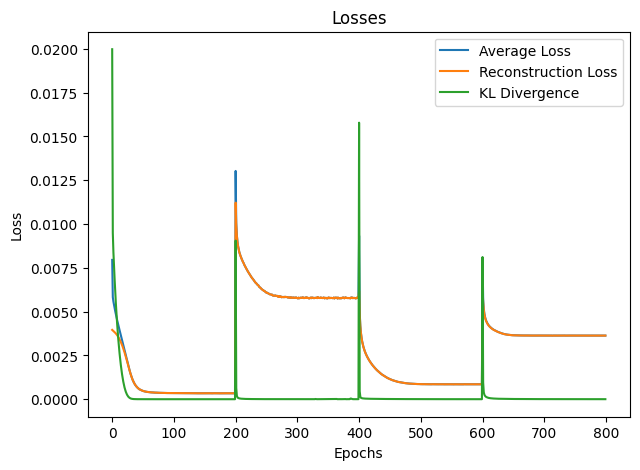

In [3]:
#test

class Encoder(nn.Module):
    def __init__(self, input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, latent_dim * 2)  # mean and variance
        )

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=1)
        return mu, log_var, h


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_shape):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, output_shape),
        )

    def forward(self, z):
        x_reconstructed = self.decoder(z)
        return x_reconstructed


class VAE(nn.Module):
    def __init__(self, input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, input_shape)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var,h = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, log_var

    
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

# Assuming combined_tensor is your data
# Convert the data to float32
# dataset = TensorDataset(combined_tensor.float())

# Define the data loader
batch_size = 256  # adjust as necessary

# Split data into train, validation, and test
train_size = int(0.7 * len(dataset))  # 70% for training
valid_size = int(0.15 * len(dataset))  # 15% for validation
test_size = len(dataset) - train_size - valid_size  # 15% for testing

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Hyperparameters
# input_shape = combined_tensor.shape[1] * combined_tensor.shape[2]  # modify this to match your data
# hidden_dim1 = 128  # modify as needed
# hidden_dim2 = 64  # modify as needed
# hidden_dim3 = 24  # modify as needed
# latent_dim = 2  # modify as needed
# lr = 5e-5  # learning rate
# n_epochs = 200  # modify as needed
# beta = 0.2


# Lists to store losses for each epoch
avg_losses = []
avg_recon_losses = []
avg_kl_divs = []


input_shape = combined_tensor.shape[1] * combined_tensor.shape[2]  # modify this to match your data
hidden_dim1 = 24  # modify as needed
hidden_dim2 = 16  # modify as needed
hidden_dim3 = 12  # modify as needed
latent_dim = 2  # modify as needed
lr = 5e-5  # learning rate
n_epochs = 200  # modify as needed
beta = 0.2
    
# Model, optimizer, and loss function
model = VAE(input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)  # Make sure you're using the correct optimizer
loss_fn = nn.MSELoss()  # And the correct loss function

# Define the label order
label_order = [0, 1, 2, 3]  # Modify this to define the order of labels

def train(epoch, model, optimizer, loss_fn, train_loader):
        model.train()
        train_loss = 0
        total_recon_loss = 0
        total_kl_div = 0
        for i, (batch_data, batch_labels) in enumerate(train_loader):  # using train_loader instead of dataloader
    #         batch_data = batch[0]  # get the data from the batch

            optimizer.zero_grad()

            # Flatten the data
            batch_data = batch_data.view(batch_data.size(0), -1)
            batch_data = batch_data.float()

            reconstructed_batch, mu, log_var = model(batch_data)

            # Loss: reconstruction loss + KL divergence
            recon_loss = loss_fn(reconstructed_batch, batch_data)
            kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = recon_loss + beta*kl_divergence

            loss.backward()
            train_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_div += kl_divergence.item()
            optimizer.step()

        avg_loss = train_loss / len(train_loader.dataset)
        avg_recon_loss = total_recon_loss / len(train_loader.dataset)
        avg_kl_div = total_kl_div / len(train_loader.dataset)
        print(f'====> Epoch: {epoch} Average loss: {avg_loss}, Recon Loss: {avg_recon_loss}, KL Div: {avg_kl_div}')

        return avg_loss, avg_recon_loss, avg_kl_div


# Training loop for each label
for label in label_order:
    print(f"Training for label {label}")
    
    # Filter the dataset for the current label
    filtered_dataset = [data for data in dataset if data[1] == label]
    
    train_size = int(0.7 * len(filtered_dataset))
    valid_size = int(0.15 * len(filtered_dataset))
    test_size = len(filtered_dataset) - train_size - valid_size
    train_dataset, valid_dataset, test_dataset = random_split(filtered_dataset, [train_size, valid_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    # Training
    for epoch in range(1, n_epochs + 1):
        avg_loss, avg_recon_loss, avg_kl_div = train(epoch, model, optimizer, loss_fn, train_loader)
        avg_losses.append(avg_loss)
        avg_recon_losses.append(avg_recon_loss)
        avg_kl_divs.append(avg_kl_div)


    
import matplotlib.pyplot as plt

# Plot the losses
plt.figure(figsize=(7,5))
plt.plot(avg_losses, label='Average Loss')
plt.plot(avg_recon_losses, label='Reconstruction Loss')
plt.plot(avg_kl_divs, label='KL Divergence')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Get encoded representations (h values) for all data points
encoded_representations = []
labels_list = []

model.eval()
for label in label_order:
    print(f"Training for label {label}")
    
    # Filter the dataset for the current label
    filtered_dataset = [data for data in dataset if data[1] == label]
    
    train_size = int(0.7 * len(filtered_dataset))
    valid_size = int(0.15 * len(filtered_dataset))
    test_size = len(filtered_dataset) - train_size - valid_size
    train_dataset, valid_dataset, test_dataset = random_split(filtered_dataset, [train_size, valid_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    with torch.no_grad():
        for batch in test_loader:
            batch_data = batch[0]
            batch_data = batch_data.view(batch_data.size(0), -1)
            batch_data = batch_data.float()
            _, _, h = model.encoder(batch_data)  # Get the encoded representation (h value) directly
            
            encoded_representations.append(h)
            labels_list.extend([label] * len(batch_data))  # Extend with label repeated for each data point

# Convert the encoded representations to a numpy array
encoded_representations = torch.cat(encoded_representations, dim=0).numpy()
labels = np.array(labels_list)

# Create a list of colors for each label
colors = ['r', 'g', 'b', 'c']  # Add more colors as needed

# Create a scatter plot with different colors for each label
plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    mask = labels == label
    plt.scatter(encoded_representations[mask, 0], encoded_representations[mask, 1], 
                alpha=0.5, s=3, label=f'Label {label}', color=colors[label])

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Visualization of Encoded Representations (h values)')
plt.legend()
plt.show()


# latent space plot

In [ ]:
def plot_latent(vae, data_loader, num_batches=100):
    vae.eval()  # Set the VAE model to evaluation mode
    all_z = []

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            x = batch.view(batch.size(0), -1)  # Flatten the data

            mu, log_var = vae.encoder(x)
            z = vae.reparameterize(mu, log_var)

            all_z.append(z)

            if i >= num_batches:
                break

    all_z = torch.cat(all_z, dim=0).cpu().numpy()

    plt.scatter(all_z[:, 0], all_z[:, 1], cmap='tab10')
    plt.colorbar()
    plt.title('Latent Space Visualization')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()


plot_latent(model, test_loader)

In [ ]:
def plot_latent(model, data_loader):
    # Set the model to evaluation mode
    model.eval()
    latents = []
    for i, batch in enumerate(data_loader):
        x = batch  # Get only the data (ignore the label)
        x = x.view(x.size(0), -1)
        mu, log_var = model.encoder(x)
        z = model.reparameterize(mu, log_var)
        latents.append(z.detach().cpu().numpy())
    latents = np.concatenate(latents, axis=0)
    plt.figure(figsize=(7,5))
    plt.scatter(latents[:, 0], latents[:, 1], s=2)
    plt.colorbar()
    plt.show()

# Call the function to plot latent representations
plot_latent(model, test_loader)


# see the output

In [4]:
from collections import defaultdict
import pandas as pd

def test_model(model, test_loader):
    model.eval()
    
    # 각 레이블에 대한 원본 및 재구성 데이터 프레임을 저장합니다.
    original_dfs = defaultdict(list)
    reconstructed_dfs = defaultdict(list)

    with torch.no_grad():
        for i, (batch_data, batch_labels) in enumerate(test_loader):
            batch_data = batch_data.view(batch_data.size(0), -1)
            batch_data = batch_data.float()
            reconstructed_batch, _, _ = model(batch_data)

            original_data = batch_data.detach().cpu().numpy()
            reconstructed_data = reconstructed_batch.detach().cpu().numpy()
            labels = batch_labels.detach().cpu().numpy()

            # 각 레이블에 대해 데이터 프레임을 생성하고 저장합니다.
            for label, orig, recon in zip(labels, original_data, reconstructed_data):
                original_dfs[label].append(pd.DataFrame(orig.reshape(1, -1)))
                reconstructed_dfs[label].append(pd.DataFrame(recon.reshape(1, -1)))

    # 각 레이블의 데이터 프레임을 연결합니다.
    for label in original_dfs.keys():
        original_dfs[label] = pd.concat(original_dfs[label])
        reconstructed_dfs[label] = pd.concat(reconstructed_dfs[label])

    return original_dfs, reconstructed_dfs

# 훈련 후 함수를 호출합니다.
original_dfs, reconstructed_dfs = test_model(model, test_loader)

# 예를 들어 레이블 1에 대한 원본 및 재구성된 데이터를 가져옵니다.
label1_original_df = original_dfs[3]
label1_reconstructed_df = reconstructed_dfs[3]


In [5]:
label1_original_df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,1.0,-0.521157,1.064041,-0.643344,-1.182982,-0.197665,1.138519,-0.987338,0.972975,1.191810,...,0.036341,0.756398,0.875603,-0.596906,-1.243226,-0.490968,0.130961,0.113848,0.091370,0.092441
0,1.0,-0.388760,0.832479,-0.605602,-1.178328,-0.459738,1.215337,-0.955790,1.107480,0.990893,...,0.064317,0.856897,0.939919,-0.572147,-1.363224,-0.035861,0.030215,0.022542,-0.043778,0.061863
0,1.0,-0.541349,1.016989,-0.672604,-1.264676,-0.175052,1.272655,-1.011794,1.033702,1.071207,...,-1.000000,-0.347894,0.856177,-0.699382,-1.295950,-0.080856,0.052526,-0.084727,0.082647,-0.147471
0,1.0,-0.432241,0.956837,-0.512337,-1.347741,-0.301010,1.083956,-1.132571,0.924796,1.178126,...,0.081945,0.887085,1.002506,-0.647692,-1.109891,-0.229469,-0.150006,0.058645,0.042463,-0.115486
0,1.0,-0.606111,0.837856,-0.452883,-1.273226,0.293409,1.069070,-1.080818,1.093618,1.018025,...,0.071156,0.938479,1.046215,-0.699176,-1.395509,-0.303495,0.077619,-0.075436,0.014222,-0.048925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.0,-0.322735,0.842601,-0.570612,-1.272063,-0.530970,1.024069,-1.006588,0.976377,1.180401,...,-0.750768,-0.945988,0.804215,-0.707198,-1.396899,-0.063159,-0.091287,0.014777,-0.024353,-0.130192
0,1.0,-0.449799,0.996353,-0.689389,-1.106968,-0.290541,1.061073,-1.092605,0.880352,1.093322,...,-1.000000,-0.107942,0.995481,-0.655558,-1.364974,-0.410360,0.023341,0.038909,-0.137333,0.037935
0,1.0,-0.379043,1.048189,-0.672578,-1.110175,-0.831487,1.130449,-1.015805,1.123258,1.065249,...,-0.009253,0.668542,0.863788,-0.512717,-1.270511,0.093378,-0.030217,-0.026415,-0.080103,-0.069563
0,1.0,-0.537924,0.824838,-0.558274,-1.328056,0.127827,1.218357,-0.921067,0.981342,1.051614,...,0.116721,0.633710,0.885594,-0.675231,-1.427714,0.152697,-0.096910,-0.072785,-0.089939,0.018110


In [6]:
label1_reconstructed_df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,1.003189,-0.466990,0.920740,-0.570450,-1.246380,-0.270460,1.177762,-1.043784,1.002150,1.100873,...,-0.066145,0.467095,0.949190,-0.597030,-1.278001,-0.302427,-0.015313,0.023199,-0.013459,-0.028083
0,0.987518,-0.461637,0.916954,-0.564902,-1.230948,-0.260531,1.158805,-1.043592,1.003235,1.088140,...,-0.065222,0.453991,0.937573,-0.589097,-1.262299,-0.302236,-0.012850,0.022716,-0.012160,-0.024296
0,1.024082,-0.460451,0.926933,-0.593161,-1.251581,-0.266355,1.179382,-1.034580,0.984414,1.101722,...,-0.044515,0.445803,0.950698,-0.606636,-1.275142,-0.305287,-0.016467,0.019437,-0.014583,-0.024588
0,0.961989,-0.456195,0.910495,-0.568437,-1.216755,-0.244618,1.139927,-1.020520,0.982961,1.065583,...,-0.074299,0.417303,0.926862,-0.598759,-1.256032,-0.308808,-0.019508,0.018934,-0.009992,-0.019256
0,1.011345,-0.459561,0.922636,-0.585638,-1.240586,-0.261478,1.166615,-1.033072,0.982375,1.089062,...,-0.046400,0.440503,0.941935,-0.601906,-1.265056,-0.303813,-0.016406,0.020894,-0.013680,-0.023645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.987008,-0.451573,0.921476,-0.575247,-1.232804,-0.258971,1.146161,-1.028772,0.989700,1.087437,...,-0.068514,0.440053,0.936989,-0.595163,-1.265861,-0.298964,-0.016668,0.017168,-0.013117,-0.023629
0,1.011770,-0.458252,0.928853,-0.586179,-1.248362,-0.262819,1.173831,-1.042299,1.001359,1.106071,...,-0.057484,0.447937,0.947031,-0.605322,-1.275292,-0.300844,-0.013589,0.017411,-0.012949,-0.024236
0,0.997370,-0.456924,0.921716,-0.574436,-1.239367,-0.264680,1.162964,-1.036937,0.997196,1.095150,...,-0.067242,0.450512,0.942926,-0.600733,-1.270963,-0.299294,-0.015503,0.019466,-0.012408,-0.026319
0,1.001261,-0.455109,0.932685,-0.583689,-1.245754,-0.257320,1.165431,-1.046761,1.005310,1.106060,...,-0.062486,0.441718,0.946041,-0.607388,-1.275974,-0.300919,-0.013337,0.016372,-0.011317,-0.024616


In [7]:
# Get the first row from the dataframe
first_row = label1_reconstructed_df.iloc[0]

# Reshape it to (1000, 10)
reshaped_array = np.reshape(first_row.values, (1000, 10))

# Convert it back to a dataframe
reshaped_df = pd.DataFrame(reshaped_array)
recon_combined_tensor = torch.tensor(reshaped_df.values)


In [ ]:
replay(reshaped_df)

In [8]:
# Get the first row from the dataframe
first_row = label1_original_df.iloc[0]

# Reshape it to (1000, 10)
reshaped_array = np.reshape(first_row.values, (1000, 10))

# Convert it back to a dataframe
reshaped_df = pd.DataFrame(reshaped_array)
ori_combined_tensor = torch.tensor(reshaped_df.values)


In [ ]:
replay(reshaped_df)

In [ ]:
recon_combined_tensor-ori_combined_tensor

In [9]:
# Flatten the tensors
flattened_ori = ori_combined_tensor.flatten()
flattened_recon = recon_combined_tensor.flatten()

# Calculate the Euclidean distance
euclidean_distance = torch.norm(flattened_ori - flattened_recon)


print(euclidean_distance)


tensor(112.0241)


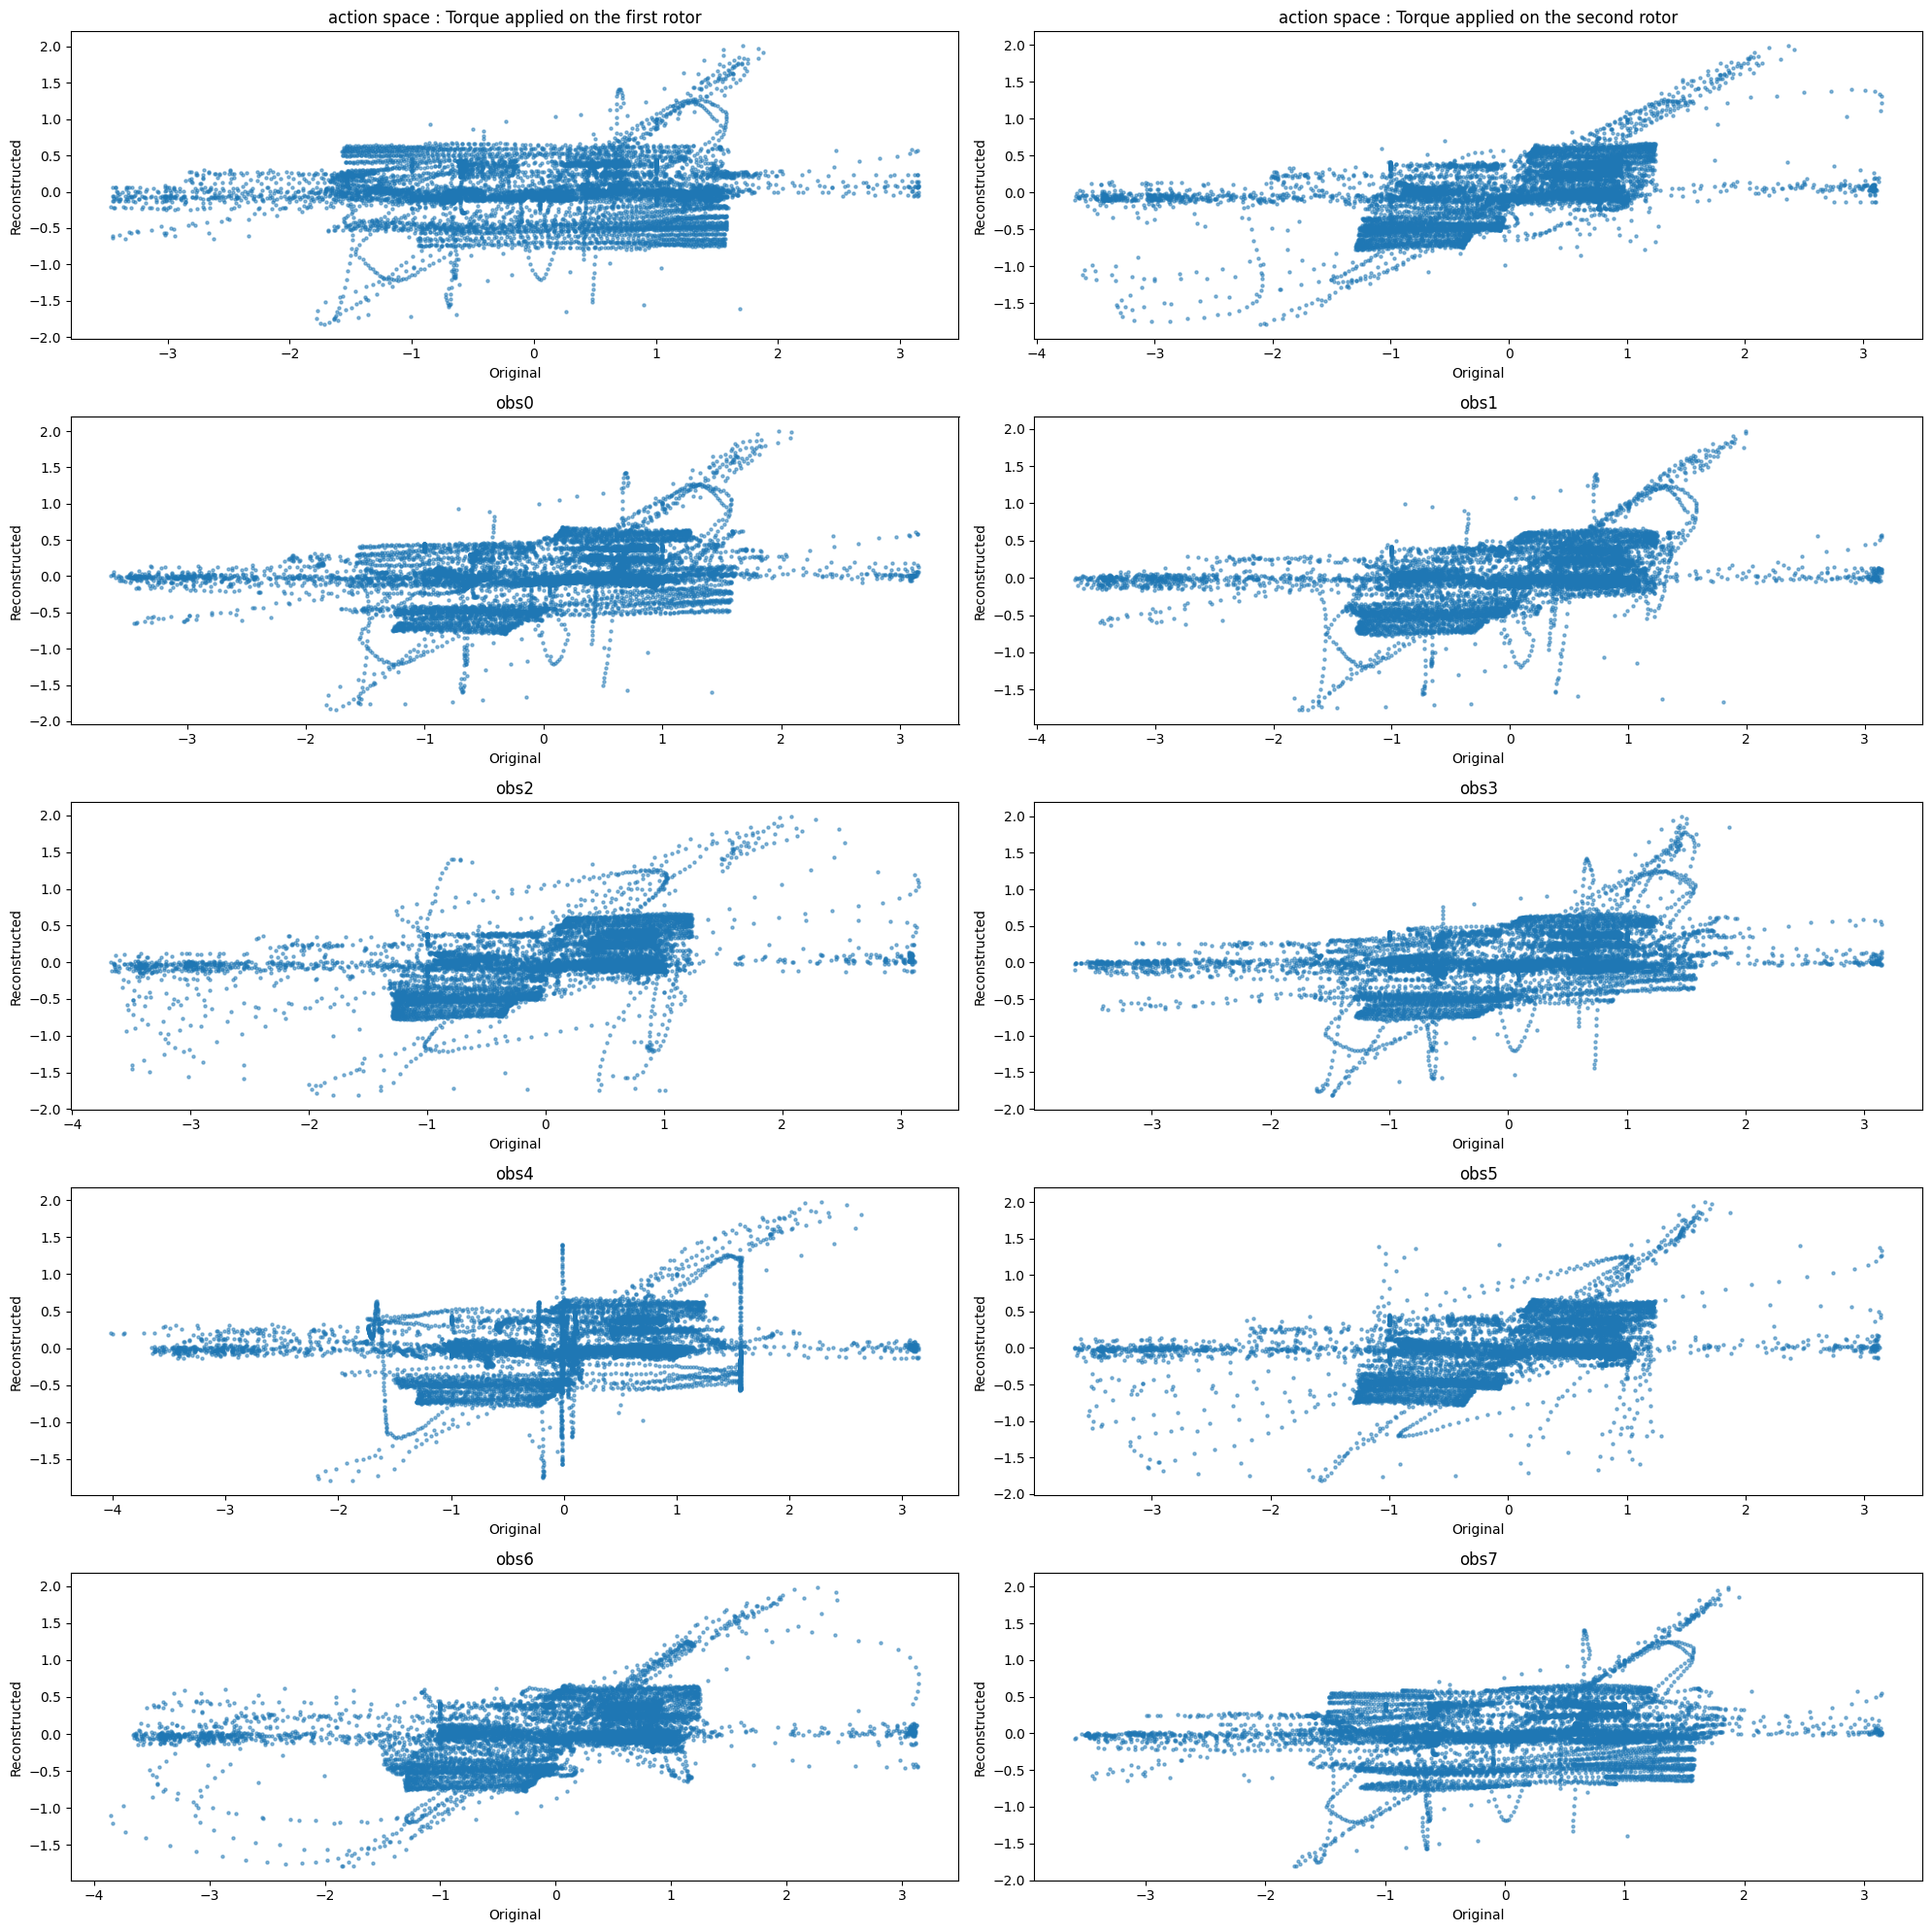

In [10]:
ori_combined_np = label1_original_df.to_numpy()
recon_combined_np = label1_reconstructed_df.to_numpy()

# Column names
column_names = ['action space : Torque applied on the first rotor', 
                'action space : Torque applied on the second rotor', 
                'obs0', 'obs1', 'obs2', 'obs3', 'obs4', 'obs5', 'obs6', 'obs7']

# Create a figure
plt.figure(figsize=(20, 20))

# Create subplots for each column
for i in range(10):  # Assuming you have 10 columns
    plt.subplot(5, 2, i+1)  # 5 rows and 2 columns of subplots
    plt.scatter(ori_combined_np[i, :], recon_combined_np[i, :], alpha=0.5, s=5)
    plt.title(column_names[i])
    plt.xlabel('Original')
    plt.ylabel('Reconstructed')

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
ori_combined_np.shape

In [ ]:
# Column names
column_names = ['action space : Torque applied on the first rotor', 
                'action space : Torque applied on the second rotor', 
                'obs0', 'obs1', 'obs2', 'obs3', 'obs4', 'obs5', 'obs6', 'obs7']

# Create a figure
plt.figure(figsize=(20, 20))

# Create subplots for each column
for i in range(10):  # Assuming you have 10 columns
    plt.subplot(5, 2, i+1)  # 5 rows and 2 columns of subplots
    plt.scatter(ori_combined_np[:, i], recon_combined_np[:, i], alpha=0.2)
    plt.title(column_names[i])
    plt.xlabel('Original')
    plt.ylabel('Reconstructed')

# Display the plot
plt.tight_layout()
plt.show()


Training for label 0
Training for label 1
Training for label 2
Training for label 3


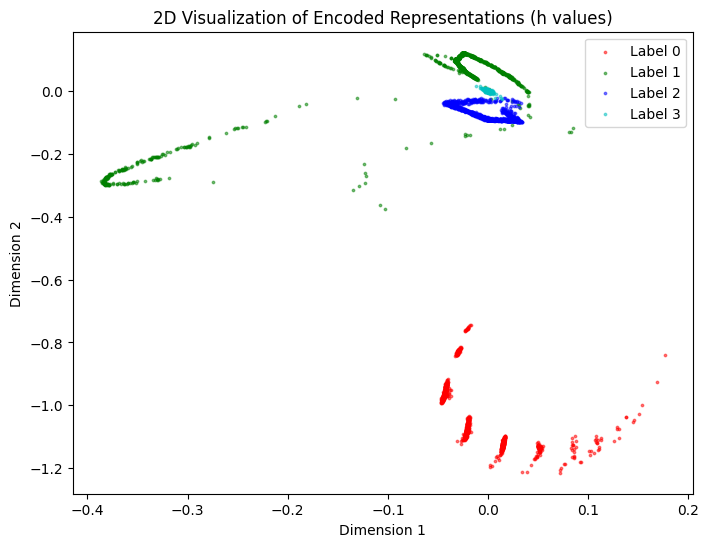

In [14]:
# Get encoded representations (h values) for all data points
encoded_representations = []
labels_list = []

model.eval()
for label in label_order:
    print(f"Training for label {label}")
    
    # Filter the dataset for the current label
    filtered_dataset = [data for data in dataset if data[1] == label]
    
    train_size = int(0.7 * len(filtered_dataset))
    valid_size = int(0.15 * len(filtered_dataset))
    test_size = len(filtered_dataset) - train_size - valid_size
    train_dataset, valid_dataset, test_dataset = random_split(filtered_dataset, [train_size, valid_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    with torch.no_grad():
        for batch in test_loader:
            batch_data = batch[0]
            batch_data = batch_data.view(batch_data.size(0), -1)
            batch_data = batch_data.float()
            _, _, h = model.encoder(batch_data)  # Get the encoded representation (h value) directly
            
            encoded_representations.append(h)
            labels_list.extend([label] * len(batch_data))  # Extend with label repeated for each data point

# Convert the encoded representations to a numpy array
encoded_representations = torch.cat(encoded_representations, dim=0).numpy()
labels = np.array(labels_list)

# Create a list of colors for each label
colors = ['r', 'g', 'b', 'c']  # Add more colors as needed

# Create a scatter plot with different colors for each label
plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    mask = labels == label
    plt.scatter(encoded_representations[mask, 0], encoded_representations[mask, 1], 
                alpha=0.5, s=3, label=f'Label {label}', color=colors[label])

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Visualization of Encoded Representations (h values)')
plt.legend()
plt.show()
